In [2]:
from keras import layers
from keras import models
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import os

In [14]:
def plot_history(hst):
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hst.history['loss'], label='train')
    plt.plot(hst.history['val_loss'], label='test')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot([round(100*e, 2) for e in hst.history['accuracy']], label='train')
    plt.plot([round(100*e, 2) for e in hst.history['val_accuracy']], label='test')
    plt.title('Accuracy')    

    plt.ylim(0, 100)
    plt.legend()
    plt.tight_layout()
    plt.show()

Частина 1. Побудова архітектури згорткової нейронної мережі

In [7]:

model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),

    layers.Dense(10, activation="softmax")
])


/Users/anastsiasmirnova/.local/share/virtualenvs/goit-ds-hw-12-_31BA9zN/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
model_1.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [12]:
history  =  model_1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=64 )
model_1.save("Models/model_1_cnn.h5")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7116 - loss: 0.7822 - val_accuracy: 0.8455 - val_loss: 0.4138
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8671 - loss: 0.3599 - val_accuracy: 0.8748 - val_loss: 0.3421
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8909 - loss: 0.2981 - val_accuracy: 0.8889 - val_loss: 0.2948
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9048 - loss: 0.2579 - val_accuracy: 0.8913 - val_loss: 0.2944
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9127 - loss: 0.2339 - val_accuracy: 0.9027 - val_loss: 0.2711
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9223 - loss: 0.2104 - val_accuracy: 0.9018 - val_loss: 0.2767
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9294 - loss: 0.1928 - val_accuracy: 0.8997 - val_loss: 0.2799
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9361 - loss: 0.1748 - 

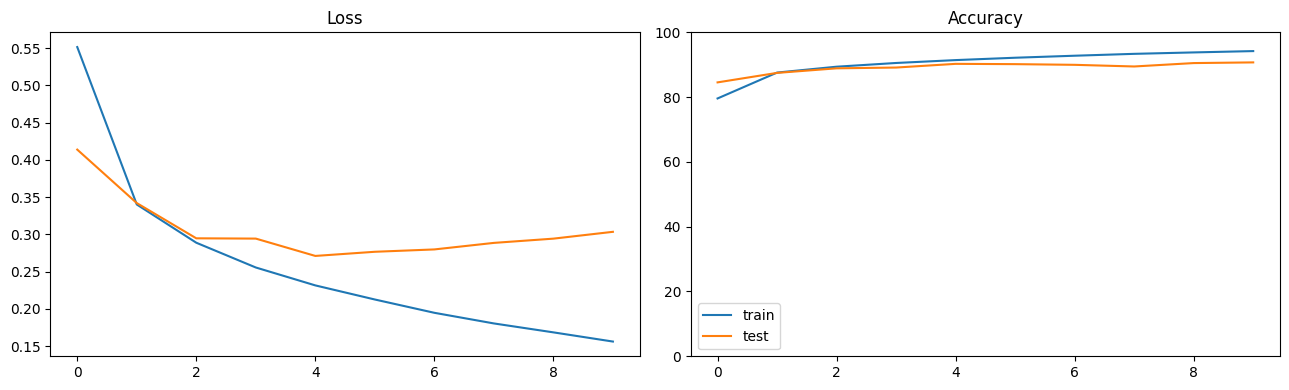

In [15]:
plot_history(history)

Частина 2. Використання передвиборних мереж. Виділення ознак

In [16]:
import cv2

train_images_3D = np.zeros((60000, 32, 32, 3), dtype=train_images.dtype)
test_images_3D = np.zeros((10000, 32, 32, 3), dtype=train_images.dtype)

for i in range(train_images.shape[0]):
    # Resize the single image (28, 28, 1) to (224, 224, 3)
    resized_TR_image = cv2.resize(train_images[i, :, :, 0], (32, 32), interpolation=cv2.INTER_LINEAR)
    train_images_3D[i] = np.repeat(resized_TR_image[:, :, np.newaxis], 3, axis=2)
    if i < 10000:
        resized_T_image = cv2.resize(test_images[i, :, :, 0], (32, 32), interpolation=cv2.INTER_LINEAR)
        test_images_3D[i] = np.repeat(resized_T_image[:, :, np.newaxis], 3, axis=2)
    




In [17]:
batch_size = 1000
steps_per_epoch = len(train_images_3D)//batch_size
epochs = 50
validation_steps = len(test_images_3D)//batch_size

In [18]:


train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_datagen.fit(train_images_3D)
test_datagen.fit(test_images_3D)

train_generator = train_datagen.flow(train_images_3D, train_labels, batch_size=batch_size)

validation_generator = test_datagen.flow(test_images_3D, test_labels, batch_size=batch_size)

In [20]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))

conv_base.trainable = False

model_2= models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3, 
    verbose = 1
)

history_1 = model_2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)



/Users/anastsiasmirnova/.local/share/virtualenvs/goit-ds-hw-12-_31BA9zN/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - acc: 0.1233 - loss: 2.3859 - val_acc: 0.2100 - val_loss: 2.2523
Epoch 2/50
48/60 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - acc: 0.2169 - loss: 2.2113

KeyboardInterrupt: 

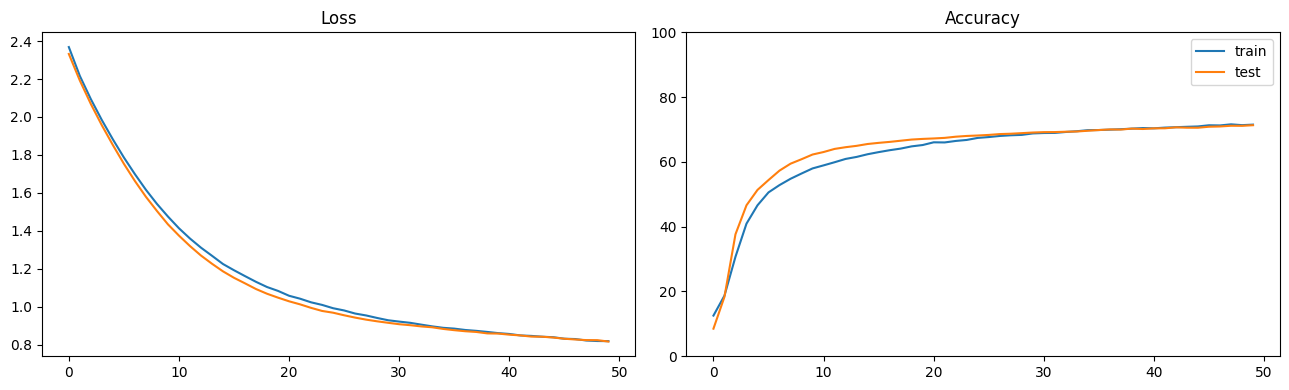

In [25]:
model_1.save("Models/model_2_cnn.h5")
plot_history(history_1)

Частина 2. Використання передвиборних мереж. Донавчання

In [17]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))

In [18]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block4_conv2":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 11,932,938 (45.52 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

In [24]:
# creating callback that saves weights only during training
checkpoint_path_2 = r"C:\Users\Anastasiia\Documents\PythonProjects\Models\Model_3_ckpt.weights.h5"
checkpoint_dir_2 = os.path.dirname(checkpoint_path_2)

cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)

In [29]:
history_2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping,cp_callback_2]
)

C:\Users\Anastasiia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5273 - loss: 1.4729
Epoch 1: saving model to C:\Users\Anastasiia\Documents\PythonProjects\Models\Model_3_ckpt.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - acc: 0.5292 - loss: 1.4663 - val_acc: 0.7494 - val_loss: 0.7039
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7491 - loss: 0.6936
Epoch 2: saving model to C:\Users\Anastasiia\Documents\PythonProjects\Models\Model_3_ckpt.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - acc: 0.7492 - loss: 0.6932 - val_acc: 0.7989 - val_loss: 0.5526
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7724 - loss: 0.6168
Epoch 3: saving model to C:\Users\Anastasiia\Documents\PythonProjects\Models\Model_3_ckpt.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - acc: 0.7725 - loss: 0.6165 - val_acc: 0.7946 - val_loss: 0.5339
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7939 - loss: 0.5576
Epoch 4: saving model to C:\Users\Anastasiia\Documents\PythonProjec

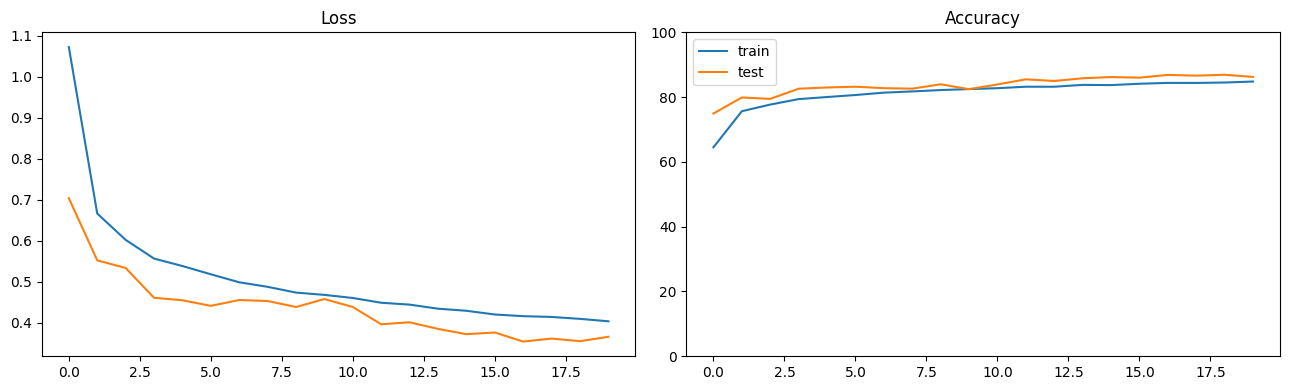

In [30]:
plot_history(history_2)

In [46]:
train_images_3D.shape

(60000, 32, 32, 3)